# Mountain Car
### This notebook attempts to solve the Mountain car-V0 problem[part of OpenAI's gym environments] using Sarsa & Tiling
### Description of problem: 
### A continuous state environment, where the agent starts at a random position and attempts to reach the top of the right hill in the shortest time possible. All timestep rewards=-1 except for reaching goal. Episode terminates when agent reaches goal state.

# Part 1: Agent Implementation[Sarsa]

#### Import modules 

In [1]:
from tqdm import tqdm
import gym
import numpy as np
import tiles3 as tc
import matplotlib.pyplot as plt

#### Create TileCoder class 

Since we are implementing tiling, we create a TileCoder class which will take state inputs to give active tiles for that state \
1) init() method initialises 3 variables: \
&ensp; a) iht_size, the size of the hash table used in tile3 module \
&ensp; b) num_tiles, the number of tiles for each tiling.[Note: total tiles for each tiling=num_tilesxnum_tiles] \
&ensp; c) num_tilings, the number of tilings used \

2) get_tiles() method takes state variables[position & velocity] & returns tiles occupied by the state \
&ensp; We need to scale both position & velocity to range[0-1] before passing to tc.tiles

#### Create SarsaAgent class 

Instead of defining separate functions that define the agent's behavior, we shall attempt to combine them under a single class \
1) init() method initialises 13 variables which will be used in the various methods \
2) agent_init() method sets the values of 10 variables upon training start \
3) select_action() method takes tiles for action-values calculation according to the logic below: \
&ensp; a) input tiles refer to the the active tiles for the state \
&ensp; b) use tiles as column indices to filter for weights corresponding to active tiles for the state \
&ensp; c) we then loop through each action[each row] in weights & sum up the weights for each row \
&ensp; d) result will be Q(s,a) for that particular state-action pair \
&ensp; e) depending on action probability, we either take a random choice or greedy action that gives maximum Q(s,a) for that state

4) get_tiles() obtains active tiles given a state input \
5) agent_step() updates the active weights for the state[if next state is non-terminal] using the logic below: \
&ensp; a) calculate delta = reward + self.discount*next_action_value - action_value \
&ensp; b) initialise grad = np.zeros_like(self.weights) \
&ensp; c) recall that gradients for active weights = 1[we can use grad[action][active_tiles] = 1 to achieve this] \
&ensp; d) finally, update weights using self.weights += self.step_size * delta * grad

6) agent_end() updates the active weights for the state[if next state is terminal]. Only difference is delta = reward - action_value \

7) select_optimal_action() implements optimal action for each state[used for rendering only]


In [2]:
class TileCoder():
    def __init__(self, iht_size=4096, num_tiles=8, num_tilings=8):
        self.iht_size = tc.IHT(iht_size)
        self.num_tiles = num_tiles
        self.num_tilings = num_tilings
        
    def get_tiles(self, position, velocity):
        scaled_pos = (position+1.2)/(1.8)*self.num_tiles
        scaled_vel = (velocity+0.07)/0.14*self.num_tiles
        tiles = tc.tiles(self.iht_size, self.num_tilings, [scaled_pos,scaled_vel])
        return np.array(tiles)
    
class SarsaAgent():
    def __init__(self):
        self.last_action = None
        self.step_size = None
        self.discount = None
        self.epsilon = None
        self.num_tiles = None
        self.num_tilings = None
        self.num_actions = None
        self.iht_size = None
        self.weights = None
        self.init_weights = None
        self.tc = None
        self.last_action = None
        self.previous_tiles = None
        
    def agent_init(self):
        self.step_size = 0.04
        self.discount = 0.9
        self.epsilon = 0.1
        self.num_tiles = 8
        self.num_tilings = 8
        self.num_actions = 3
        self.iht_size = self.num_tiles**4
        self.init_weights = round(np.random.random(),3)
        self.weights = np.ones((self.num_actions,self.iht_size)) * self.init_weights
        self.tc = TileCoder(self.iht_size,self.num_tiles,self.num_tilings)
        
    def select_action(self, tiles):
        action_values = np.zeros(self.num_actions)
        for i in range(self.num_actions):
            action_values[i] = self.weights[i][tiles].sum()
        action_prob = np.random.random()
        if action_prob < self.epsilon:
            selected_action = np.random.choice(self.num_actions)
        else:
            selected_action = np.argmax(action_values)
        return selected_action, action_values[selected_action]
    
    def get_tiles(self,state):
        pos, vel = state
        tiles = self.tc.get_tiles(pos,vel)
        return tiles
    
    def agent_step(self):
        delta = reward + self.discount*next_action_value - action_value
        grad = np.zeros_like(self.weights)
        grad[action][active_tiles] = 1
        self.weights += self.step_size * delta * grad
        
    def agent_end(self):
        delta = reward - action_value
        grad = np.zeros_like(self.weights)
        grad[action][active_tiles] = 1
        self.weights += self.step_size * delta * grad
        
    def select_optimal_action(self, tiles):
        action_values = np.zeros(self.num_actions)
        for i in range(self.num_actions):
            action_values[i] = self.weights[i][tiles].sum()
        selected_action = np.argmax(action_values)
        return selected_action

#### Train agent 

Let's train our agent for 200 episodes \
Logic is as follows: 

Initialise agent using agent_init()

For every episode, \
1) reset environment(env.reset()) \
2) initialise timesteps to 0 \
3) reset terminate to False 

For each timestep when terminate is False: \
1) get active tiles for current state \
2) choose current action using active tiles \
3) pass current action to env.step() to obtain next_state, reward & terminate \
4) increment timesteps \
5) if next_state is not terminal state: \
&ensp;    a) get next_tiles using next_state \
&ensp;    b) choose next_action \
&ensp;    c) run agent_step() to update weights \
&ensp;    d) set state to next_state \
&ensp;    e) set action to next_action \
6) if next_state is terminal:   
&ensp;    a) run agent_end() to update weights \
7) append timesteps to episode_timesteps

In [3]:
episodes = 200
episode_timesteps = []
env = gym.make('MountainCar-v0', new_step_api=True)
agent = SarsaAgent()
agent.agent_init()
for episode in tqdm(range(episodes)):
    state = env.reset()
    terminate = False
    timesteps = 0
    while not terminate:
        active_tiles = agent.get_tiles(state)
        action, action_value = agent.select_action(active_tiles)
        next_state, reward, terminate, truncated, info = env.step(action)
        timesteps += 1
        if not terminate:
            next_tiles = agent.get_tiles(next_state)
            next_action, next_action_value = agent.select_action(next_tiles)
            agent.agent_step()
            state = next_state
            action = next_action
        else:
            agent.agent_end()
            episode_timesteps.append(timesteps)
            

100%|██████████| 200/200 [00:04<00:00, 43.14it/s]


#### Plot timesteps 

Let's plot timesteps to reach termination for each episode \
Observe that it follows a decreasing trend from episode 0 \
Interestingly, there is a spike between episode 150 & 175 \
This is probably due to random start of agent in a totally new position, whose surrounding action values have not been updated much, therefore causing it to experience a long series of timesteps before reaching termination

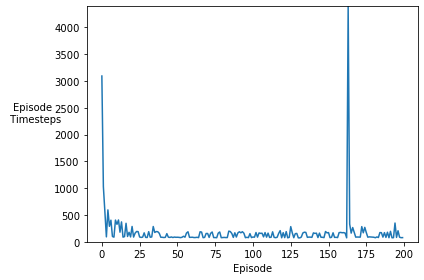

In [4]:
plt.plot(episode_timesteps)
plt.xlabel("Episode")
plt.ylabel("Episode \n Timesteps",rotation=0, labelpad=20)
plt.ylim(0,round(max(episode_timesteps)))
plt.tight_layout()
plt.show()

#### Rendering 

Let's observe our agent in action \
Observe that for all 10 episodes, our agent is able to complete the task successfully

In [5]:
env = gym.make('MountainCar-v0', new_step_api=True, render_mode='human')
for episode in range(10):
    state = env.reset()
    done = False
    while not done:
        active_tiles = agent.get_tiles(state)
        best_action = agent.select_optimal_action(active_tiles)
        next_state, reward, done, truncated, info = env.step(int(best_action))
        state = next_state
        env.render()
    
    if done:  
        state = env.reset()
        env.render()
env.reset()        
env.close() 

# Part 2: Parameter Study

What about other values for tiles & tilings? \
How does changing these values affect the convergence rate? \
Let's investigate (tiles,tilings) for the values (8,8), (4,32) & (16,2) 

In [29]:
episodes = 100
range_timesteps = []
all_timesteps = []

for tiles, tilings in [[8,8],[4,32],[16,2]]:
    for i in range(5):
        episode_timesteps = []
        env = gym.make('MountainCar-v0', new_step_api=True)
        agent = SarsaAgent()
        agent.agent_init()
        agent.num_tiles = tiles
        agent.num_tilings = tilings
        for episode in tqdm(range(episodes)):
            state = env.reset()
            terminate = False
            timesteps = 0
            while not terminate:
                active_tiles = agent.get_tiles(state)
                action, action_value = agent.select_action(active_tiles)
                next_state, reward, terminate, truncated, info = env.step(action)
                timesteps += 1
                if not terminate:
                    next_tiles = agent.get_tiles(next_state)
                    next_action, next_action_value = agent.select_action(next_tiles)
                    agent.agent_step()
                    state = next_state
                    action = next_action
                else:
                    agent.agent_end()
                    episode_timesteps.append(timesteps)
        range_timesteps.append(episode_timesteps)  
    all_timesteps.append(np.mean(np.array(range_timesteps), axis=0))    

100%|██████████| 100/100 [00:02<00:00, 40.00it/s]


#### Plot episode timesteps  

Interestingly, although num_tiles=4,num_tilings=16 started off with the highest timesteps, it is able to converge similarly with the other 2 parameter sets at almost the same time

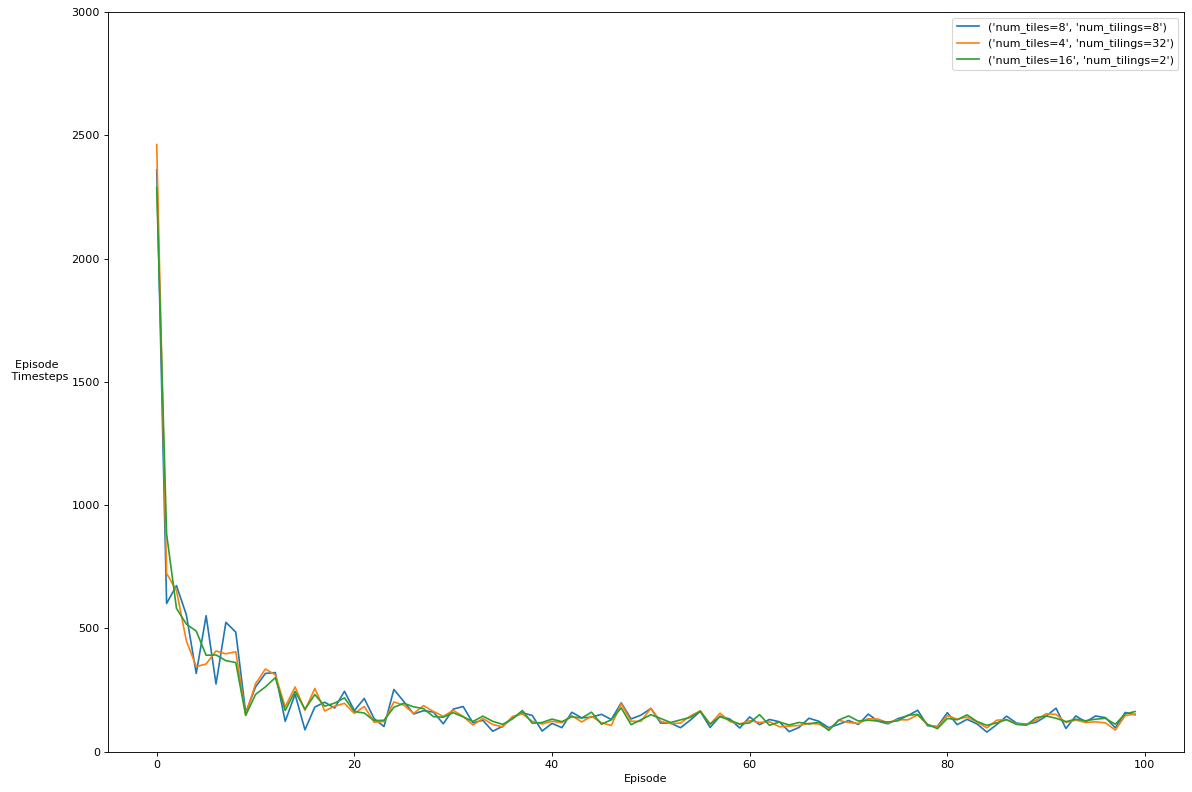

In [31]:
plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(all_timesteps[0])
plt.plot(all_timesteps[1])
plt.plot(all_timesteps[2])
plt.xlabel("Episode")
plt.ylabel("Episode \n Timesteps",rotation=0, labelpad=30)
plt.ylim(0,3000)
plt.legend([("num_tiles=8","num_tilings=8"),("num_tiles=4","num_tilings=32"),("num_tiles=16","num_tilings=2")])
plt.tight_layout()
plt.show()

#### Conclusion 

This is the first time we implement an agent in a continuous state environment. As opposed to previous gridworld environments, a continuous state environment means that we are no longer able to store action values for each state in a tabular format. Instead, we rely on weights to estimate each state's action value at each timestep before using them to implement the next action. With this slightly more-complicated method, we are able to achieve a well-trained agent that is able to solve the environment efficiently. 

We also conducted a rough study of different parameter sets. From our observed results, it seems that even using num_tiles=4 & num_tilings=32 is able to achieve similar results as our params in Part 1